<a href="https://colab.research.google.com/github/HMUNACHI/Atari-Breakout-Deep-Q-Network/blob/main/Face_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# comment out after executing
!unzip processed_celeba_small.zip

In [ ]:
data_dir = 'processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

In [ ]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [ ]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    transform = transforms.Compose([transforms.Resize(image_size),
                                   transforms.ToTensor()]) 
    image_dataset = datasets.ImageFolder(data_dir, transform)
    
    return torch.utils.data.DataLoader(image_dataset, batch_size = batch_size, shuffle=True)

In [ ]:
# Define function hyperparameters
batch_size = 128
img_size = 32

# Call function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


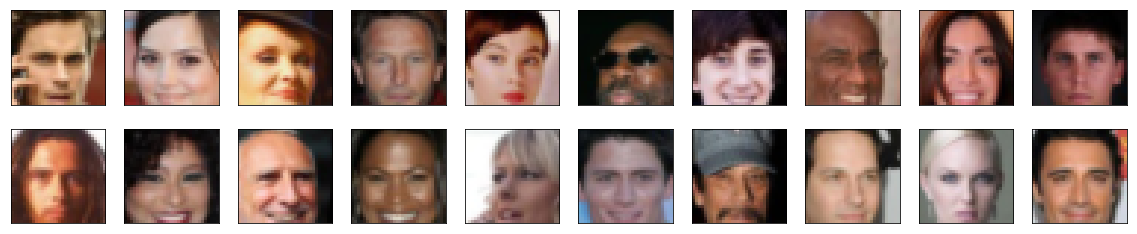

In [ ]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [ ]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    min, max = feature_range
    
    return x * (max - min) + min


In [ ]:
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9843)
Max:  tensor(0.9686)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding = 1, batch_norm= True):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                       kernel_size = kernel_size, stride = stride, padding = padding, bias = False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # (16, 16, conv_dim)
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (8, 8, conv_dim*2)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (4, 4, conv_dim*4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (2, 2, conv_dim*8)
        
        self.classifier = nn.Linear(conv_dim*8*2*2, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        
        out = x.view(-1, self.conv_dim*8*2*2)
        out = self.classifier(out)
        return out

tests.test_discriminator(Discriminator)

Tests Passed


In [ ]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [ ]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        self.fc = nn.Linear(z_size, conv_dim*8*2*2)
        
        self.t_conv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_conv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv3 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv4 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*8, 2, 2) # (batch_size, depth, 4, 4)
        
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        
        # last layer with tanh activation function
        out = self.t_conv4(x)
        out = F.tanh(out)
        
        return out

tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [ ]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # Apply initial weights to convolutional and linear layers
    classname = m.__class__.__name__
    isConvolution = classname.find('Conv') != -1
    isLinear = classname.find('Linear') != -1
    if (hasattr(m, 'weight') and isConvolution or isLinear):
        init.normal_(m.weight.data, 0.0, 0.02)
    

In [ ]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


In [ ]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), 

In [ ]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [ ]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [ ]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [ ]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #  TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()
                
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            
            g_loss.backward()
            g_optimizer.step()

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##            
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [ ]:
# set number of epochs 
n_epochs = 20

# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   20] | d_loss: 1.4315 | g_loss: 1.3032
Epoch [    1/   20] | d_loss: 1.6416 | g_loss: 6.9139
Epoch [    1/   20] | d_loss: 0.3742 | g_loss: 4.5760
Epoch [    1/   20] | d_loss: 0.4590 | g_loss: 3.1500
Epoch [    1/   20] | d_loss: 0.5149 | g_loss: 3.7676
Epoch [    1/   20] | d_loss: 0.5719 | g_loss: 4.2902
Epoch [    1/   20] | d_loss: 0.3907 | g_loss: 3.2012
Epoch [    1/   20] | d_loss: 0.7484 | g_loss: 3.3629
Epoch [    1/   20] | d_loss: 0.6127 | g_loss: 3.6251
Epoch [    1/   20] | d_loss: 0.7070 | g_loss: 2.6204
Epoch [    1/   20] | d_loss: 0.7855 | g_loss: 4.2198
Epoch [    1/   20] | d_loss: 1.6502 | g_loss: 5.8836
Epoch [    1/   20] | d_loss: 1.0107 | g_loss: 5.5042
Epoch [    1/   20] | d_loss: 0.6551 | g_loss: 4.1506
Epoch [    1/   20] | d_loss: 0.7683 | g_loss: 4.5128
Epoch [    2/   20] | d_loss: 0.5994 | g_loss: 4.2845
Epoch [    2/   20] | d_loss: 0.5313 | g_loss: 3.2397
Epoch [    2/   20] | d_loss: 0.6349 | g_loss: 2.8268
Epoch [    2/   20] | d_loss

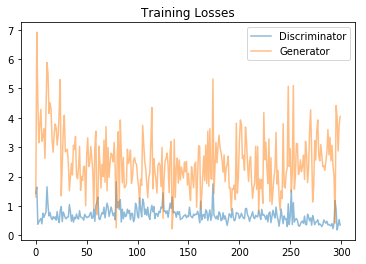

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [ ]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

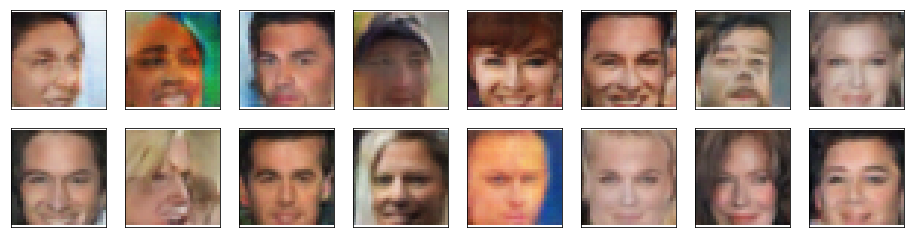

In [ ]:
_ = view_samples(-1, samples)